In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from collections import Counter
import re
import spacy
from tqdm import tqdm
from emot.emo_unicode import UNICODE_EMOJI_ALIAS, EMOTICONS_EMO

In [2]:
# let's start from the data from exploration phase.
df = pd.read_parquet(path='dataset/youtube-agg-clean-v1.parquet', engine='pyarrow')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1953 entries, 0 to 1955
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   AUTHOR   1953 non-null   string
 1   CONTENT  1953 non-null   string
 2   CLASS    1953 non-null   int64 
dtypes: int64(1), string(2)
memory usage: 61.0 KB


<BarContainer object of 20 artists>

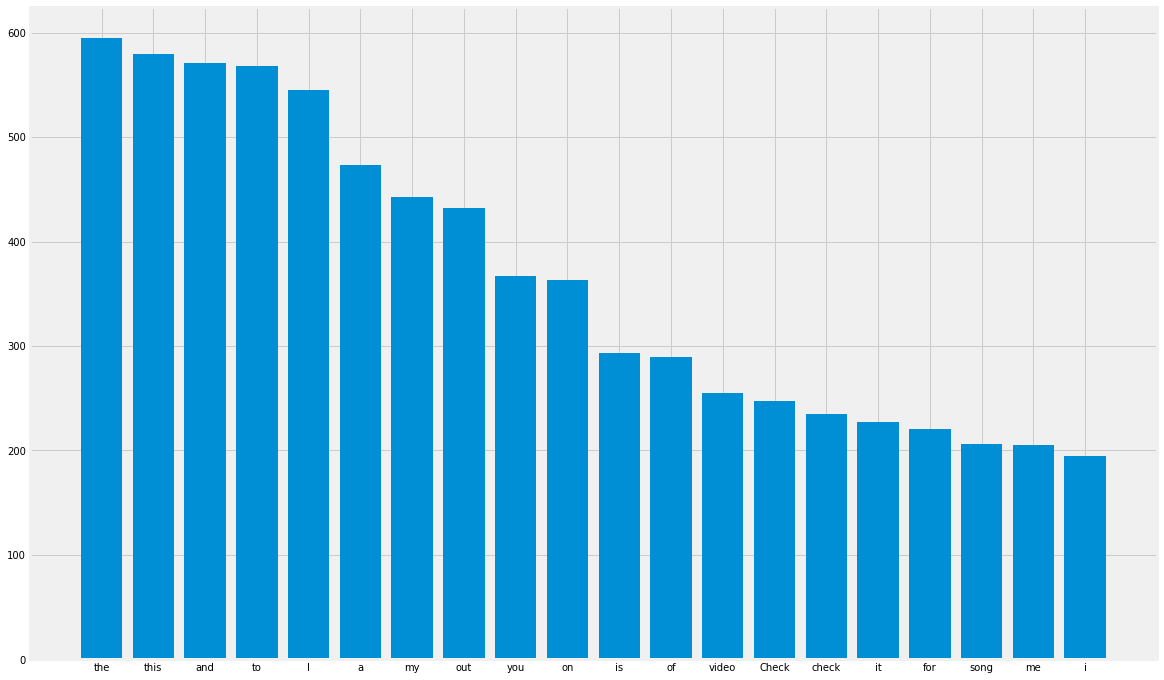

In [3]:
# the following demonstrate top 20 words in the content column.
df['CONTENT'] = df['CONTENT'].str.strip()
w = dict(Counter([i for j in df['CONTENT'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 12))
plt.bar(w.keys(), w.values())

As expected ordinary words are repeated several times. Let's see if we can find a patter in each spam non-spam class.

<BarContainer object of 20 artists>

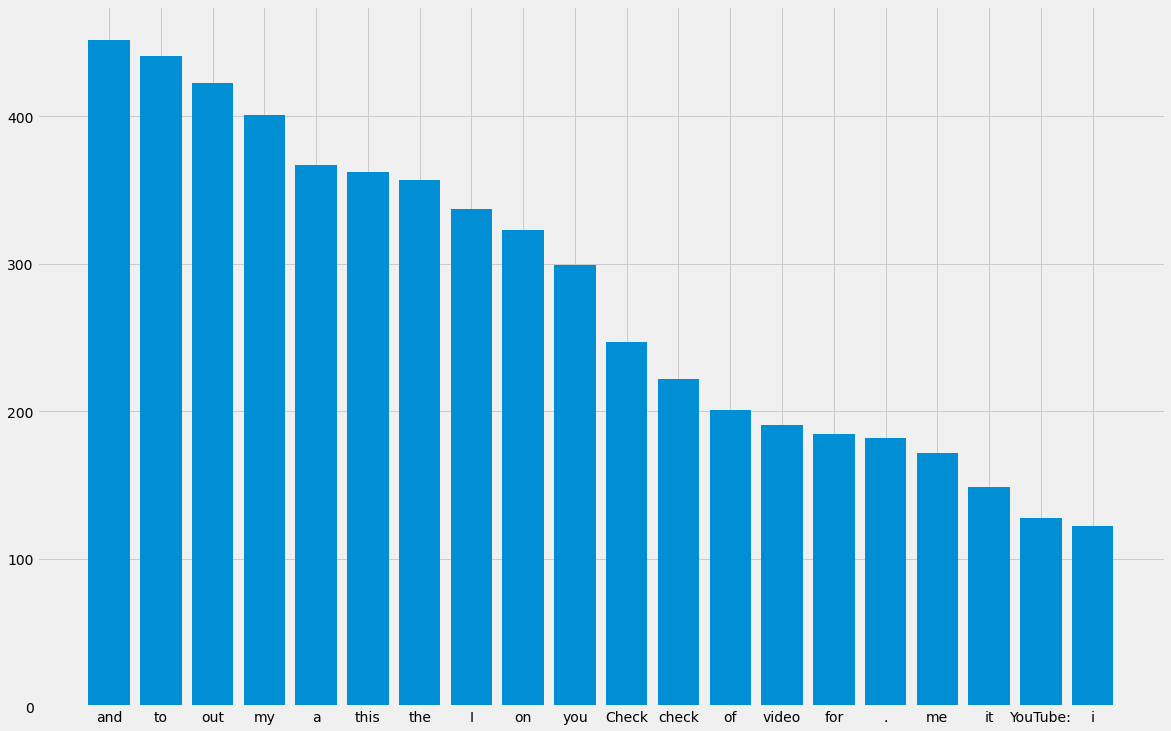

In [4]:
df_tempt = df[df['CLASS'] == 1]
w = dict(Counter([i for j in df_tempt['CONTENT'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 12))
plt.bar(w.keys(), w.values())

<BarContainer object of 20 artists>

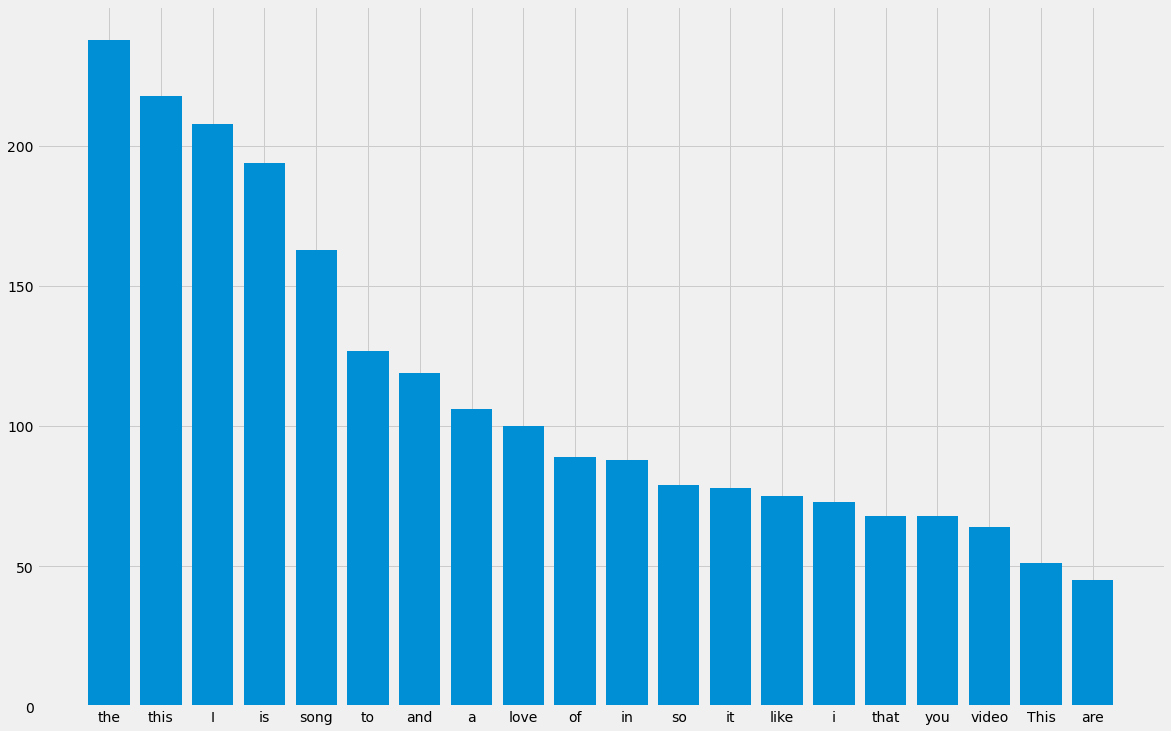

In [5]:
df_tempt = df[df['CLASS'] == 0]
w = dict(Counter([i for j in df_tempt['CONTENT'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 12))
plt.bar(w.keys(), w.values())

Invitation to check the video is dominant in spam class. We can find more features from the content column like is the url is inside the text or not.

In [6]:
regexp = re.compile(r"youtu(?:.*\/v\/|.*v\=|\.be\/)([A-Za-z0-9_\-]{11})|watch\?v=([A-Za-z0-9_\-]{11})", re.IGNORECASE)


def flag_youtube(text):
    if regexp.search(text):
        return True
    else:
        return False


df['IS_YOUTUBE'] = df['CONTENT'].apply(lambda x: flag_youtube(x))
print(len(df[df['IS_YOUTUBE'] == True].index))
df[df['IS_YOUTUBE'] == True].head(15)

33


,AUTHOR,CONTENT,CLASS,IS_YOUTUBE
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .,1,True
33,Joengz,"Check out my dubstep song ""Fireball"", made wit...",1,True
85,Alessio Siri,PSY - GANGNAM STYLE (강남스타일) M/V: http://youtu....,0,True
126,Aleksaivan Neidert,PSY - GANGNAM STYLE (강남스타일) M/V: http://youtu....,0,True
343,Leonel Hernandez,"Something to dance to, even if your sad JUST d...",0,True
377,Flynn Rider,Watch Maroon 5's latest 2nd single from V (It ...,1,True
540,William Fernandez,Katy Perry - Roar (Official): http://youtu.be/...,0,True
561,Natalya Korshunova,Katy Perry - Roar (Official): http://youtu.be/...,0,True
611,Nick McGoldrick,Check out my drum cover of E.T. here! thanks -...,1,True
616,Marie farias,Love it when I can relate to my daughter's mus...,0,True


In [7]:
# regexp = re.compile("((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
#                     re.IGNORECASE)
regexp = re.compile(
    "(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?$",
    re.IGNORECASE)


def flag_url(text):
    if regexp.search(text):
        return True
    else:
        return False


df['IS_URL'] = df['CONTENT'].apply(lambda x: flag_url(x))
print(len(df[df['IS_URL'] == True].index))
df[df['IS_URL'] == True].head(15)

222


,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL
2,Evgeny Murashkin,just for test I have to say murdev.com,1,False,True
12,Archie Lewis,https://twitter.com/GBphotographyGB,1,False,True
14,Francisco Nora,please like :D https://premium.easypromosapp.c...,1,False,True
17,OutrightIgnite,http://www.ebay.com/itm/171183229277?ssPageNam...,1,False,True
18,Tony K Frazier,http://ubuntuone.com/40beUutVu2ZKxK4uTgPZ8K,1,False,True
22,OutrightIgnite,Show your AUBURN PRIDE HERE: http://www.teespr...,1,False,True
39,Eugene Kalinin,"The projects After Effects, Music, Foto, Web s...",1,False,True
43,Didier Drogba,http://www.twitch.tv/jaroadc come follow and w...,1,False,True
47,Leonardo Baptista,http://www.avaaz.org/po/petition/Youtube_Corpo...,1,False,True
53,Wumrogue lite,https://www.facebook.com/pages/Brew-Crew-2014/...,1,False,True


Let's check the cases that we guessed it's youtube while it is not url.

In [8]:
df.loc[(df['IS_YOUTUBE'] == True) & (df['IS_URL'] == False)]

,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .,1,True,False
33,Joengz,"Check out my dubstep song ""Fireball"", made wit...",1,True,False
377,Flynn Rider,Watch Maroon 5's latest 2nd single from V (It ...,1,True,False
611,Nick McGoldrick,Check out my drum cover of E.T. here! thanks -...,1,True,False
1247,MegaEvilMonkee,Check out Em&#39;s dope new song monster here:...,1,True,False
1281,spamworld2009,watch?v=ARkglzjQuP0 Like this comment and shar...,1,True,False
1320,GreenStudioMashups,check out my Eminem &amp; Kid Cudi M a s h up ...,1,True,False
1425,Noise​Break,Like &amp; Subscribe /watch?v=5tu9gN1l310,1,True,False
1448,Terry-Lee Mackenney,everyone come and check out the new GTA 5 Game...,1,True,False
1476,Domen Kristan,CHECK OUT THESE LYRICS /watch?v=yUTTX04oyqQ,1,True,False


They all seem to have portion of youtube link. Now we can start and distill the content column and make sure we can use the words vector as a way to distinguish spam non-spam.

In [9]:
# Remove cases
# ----- Expected output -----
# Before: THIS TEXT WILL BE LOWERCASED. THIS too: ßßß
# After: this text will be lowercased. this too: ssssss
# source: https://dylancastillo.co/nlp-snippets-clean-and-tokenize-text-with-python/#tokenize-text-using-spacy
def case_folder(text):
    return text.casefold()


df['CONTENT_EDITED'] = df['CONTENT'].apply(lambda x: case_folder(x))
print(len(df.loc[~(df['CONTENT_EDITED'] == df['CONTENT'])].index))
df.loc[~(df['CONTENT_EDITED'] == df['CONTENT'])].head()

1590


,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL,CONTENT_EDITED
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,False,False,"huh, anyway check out this you[tube] channel: ..."
1,adam riyati,Hey guys check out my new channel and our firs...,1,False,False,hey guys check out my new channel and our firs...
2,Evgeny Murashkin,just for test I have to say murdev.com,1,False,True,just for test i have to say murdev.com
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .,1,True,False,watch?v=vtarggvgtwq check this out .
5,Jason Haddad,"Hey, check out my new website!! This site is a...",1,False,False,"hey, check out my new website!! this site is a..."


In [10]:
# replace emoji with their meaning
emoticons = {k: v.replace(":", "").replace("_", " ").replace(",", "").strip() for k, v in
             EMOTICONS_EMO.items()}
unicode_emoji = {k: v.replace(":", "").replace("_", " ").replace(",", "").strip() for k, v in
                 UNICODE_EMOJI_ALIAS.items()}


def convert_emoji(text, debug=False):
    main_txt = text

    cnt1 = 0
    for emoj, emot_txt in emoticons.items():
        iter_txt = text
        pattern = '|'.join([' ' + re.escape(emoj) + ' ', '^(' + re.escape(emoj) + ')+', '(' + re.escape(emoj) + ')$'])
        text = re.sub(pattern, ' ' + emot_txt + ' ', text)
        if iter_txt != text:
            cnt1 += 1

    cnt2 = 0
    for emoj, emot_txt in unicode_emoji.items():
        iter_txt = text
        text = re.sub(re.escape(emoj), ' ' + emot_txt + ' ', text)
        if iter_txt != text:
            cnt2 += 1

    if main_txt != text and debug:
        print(main_txt, '\n', text)
        print(cnt1, '\t', cnt2)
        print('\n')
        print('\n')
    return text


t = convert_emoji(df['CONTENT_EDITED'].iloc[825])
df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: convert_emoji(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
display(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head())
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

186


,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL,CONTENT_EDITED,CONTENT_EDITED_TEMP
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^,1,False,False,me shaking my sexy ass on my channel enjoy ^_^,me shaking my sexy ass on my channel enjoy Jo...
26,8-BitMusic,Hey guys! Im a 12 yr old music producer. I mak...,1,False,False,hey guys! im a 12 yr old music producer. i mak...,hey guys! im a 12 yr old music producer. i mak...
38,ii Trollercopter,Hey everyone!! I have just started my first YT...,1,False,False,hey everyone!! i have just started my first yt...,hey everyone!! i have just started my first yt...
48,Phuc Ly,go here to check the views :3,0,False,False,go here to check the views :3,go here to check the views Happy face smiley
77,Lucas Trigo,WHATS UP EVERYONE!? :-) I Trying To Showcase M...,1,False,False,whats up everyone!? :-) i trying to showcase m...,whats up everyone!? Happy face smiley i trying...


In [11]:
# removing special characters
# ----- Expected output -----
# Before: Sample text 123 !!!! Haha.... !!!! ##$$$%%%%
# After: Sample text 123  Haha

def remove_special_char(text):
    return re.sub(r"[^A-Za-z0-9\s]+", " ", text)


df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: remove_special_char(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
display(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head())
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

1427


,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL,CONTENT_EDITED,CONTENT_EDITED_TEMP
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,False,False,"huh, anyway check out this you[tube] channel: ...",huh anyway check out this you tube channel ...
1,adam riyati,Hey guys check out my new channel and our firs...,1,False,False,hey guys check out my new channel and our firs...,hey guys check out my new channel and our firs...
2,Evgeny Murashkin,just for test I have to say murdev.com,1,False,True,just for test i have to say murdev.com,just for test i have to say murdev com
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .,1,True,False,watch?v=vtarggvgtwq check this out .,watch v vtarggvgtwq check this out
5,Jason Haddad,"Hey, check out my new website!! This site is a...",1,False,False,"hey, check out my new website!! this site is a...",hey check out my new website this site is ab...


In [12]:
# removing numbers
# ----- Expected output -----
# Before: Remove these numbers: 1919191 2229292 11.233 22/22/22.
# After: Remove these numbers: .//.
def remove_number(text):
    #return re.sub(r"\b[0-9]+\b\s*", " ", text)
    return ''.join([i for i in text if not i.isdigit()])


df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: remove_number(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
display(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head())
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

658


,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL,CONTENT_EDITED,CONTENT_EDITED_TEMP
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,False,False,huh anyway check out this you tube channel ...,huh anyway check out this you tube channel ...
14,Francisco Nora,please like :D https://premium.easypromosapp.c...,1,False,True,please like d https premium easypromosapp com...,please like d https premium easypromosapp com...
17,OutrightIgnite,http://www.ebay.com/itm/171183229277?ssPageNam...,1,False,True,http www ebay com itm 171183229277 sspagename ...,http www ebay com itm sspagename strk meselx ...
18,Tony K Frazier,http://ubuntuone.com/40beUutVu2ZKxK4uTgPZ8K,1,False,True,http ubuntuone com 40beuutvu2zkxk4utgpz8k,http ubuntuone com beuutvuzkxkutgpzk
20,zhichao wang,i think about 100 millions of the views come f...,0,False,False,i think about 100 millions of the views come f...,i think about millions of the views come from...


In [13]:
# removing possessive and verb s
def remove_possessive(text):
    return text.replace("'s", ' ')


df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: remove_possessive(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
display(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head())
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

0


,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL,CONTENT_EDITED,CONTENT_EDITED_TEMP


In [14]:
# removing words with less than 3 character
def remove_short_word(text):
    return re.sub(r'\b\w{1,2}\b', '', text)


df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: remove_short_word(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
display(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head())
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

1605


,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL,CONTENT_EDITED,CONTENT_EDITED_TEMP
1,adam riyati,Hey guys check out my new channel and our firs...,1,False,False,hey guys check out my new channel and our firs...,hey guys check out new channel and our first ...
2,Evgeny Murashkin,just for test I have to say murdev.com,1,False,True,just for test i have to say murdev com,just for test have say murdev com
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^,1,False,False,me shaking my sexy ass on my channel enjoy Jo...,shaking sexy ass channel enjoy Joyful
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .,1,True,False,watch v vtarggvgtwq check this out,watch vtarggvgtwq check this out
5,Jason Haddad,"Hey, check out my new website!! This site is a...",1,False,False,hey check out my new website this site is ab...,hey check out new website this site about ...


In [15]:
# removing extra whitespaces

def remove_extra_whitespace_tabs(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()


df['CONTENT_EDITED_TEMP'] = df['CONTENT_EDITED'].apply(lambda x: remove_extra_whitespace_tabs(x))
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
display(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head())
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

1782


,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL,CONTENT_EDITED,CONTENT_EDITED_TEMP
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,False,False,huh anyway check out this you tube channel ...,huh anyway check out this you tube channel kob...
1,adam riyati,Hey guys check out my new channel and our firs...,1,False,False,hey guys check out new channel and our first ...,hey guys check out new channel and our first v...
2,Evgeny Murashkin,just for test I have to say murdev.com,1,False,True,just for test have say murdev com,just for test have say murdev com
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^,1,False,False,shaking sexy ass channel enjoy Joyful,shaking sexy ass channel enjoy Joyful
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .,1,True,False,watch vtarggvgtwq check this out,watch vtarggvgtwq check this out


In [16]:
# !python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [17]:
unique_desc = list(df['CONTENT_EDITED'].unique())
res = []
for doc in tqdm(nlp.pipe(unique_desc, n_process=1)):
    res.append(" ".join(token.lemma_ for token in doc if (not token.is_stop) and token.has_vector))
for inx, item in enumerate(tqdm(unique_desc)):
    df.loc[df[df['CONTENT_EDITED'] == item].index, 'CONTENT_EDITED_TEMP'] = res[inx]

1630it [00:02, 763.14it/s]
100%|██████████| 1630/1630 [00:00<00:00, 3730.64it/s]


In [18]:
print(len(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].index))
display(df.loc[~(df['CONTENT_EDITED_TEMP'] == df['CONTENT_EDITED'])].head())
df['CONTENT_EDITED'] = df['CONTENT_EDITED_TEMP']

1719


,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL,CONTENT_EDITED,CONTENT_EDITED_TEMP
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,False,False,huh anyway check out this you tube channel kob...,huh check tube channel
1,adam riyati,Hey guys check out my new channel and our firs...,1,False,False,hey guys check out new channel and our first v...,hey guy check new channel vid monkey monkey wh...
2,Evgeny Murashkin,just for test I have to say murdev.com,1,False,True,just for test have say murdev com,test com
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^,1,False,False,shaking sexy ass channel enjoy Joyful,shake sexy ass channel enjoy joyful
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .,1,True,False,watch vtarggvgtwq check this out,watch check


<BarContainer object of 20 artists>

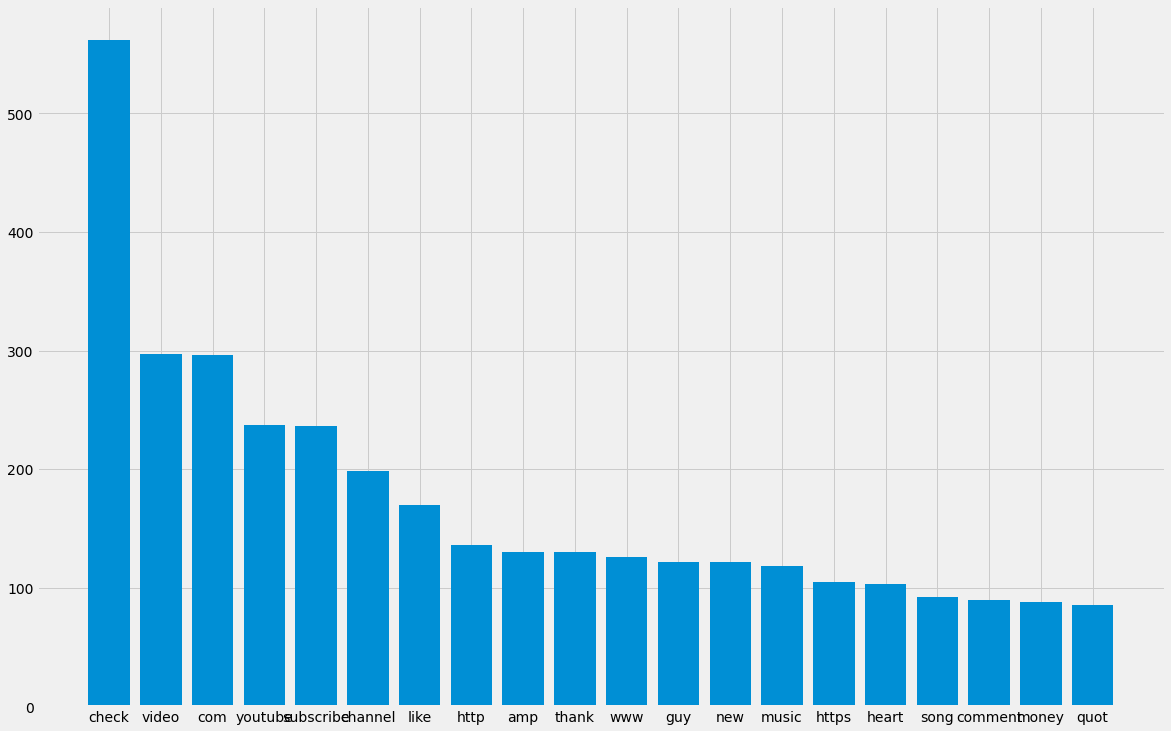

In [19]:
df_tempt = df[df['CLASS'] == 1]
w = dict(Counter([i for j in df_tempt['CONTENT_EDITED'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 12))
plt.bar(w.keys(), w.values())

<BarContainer object of 20 artists>

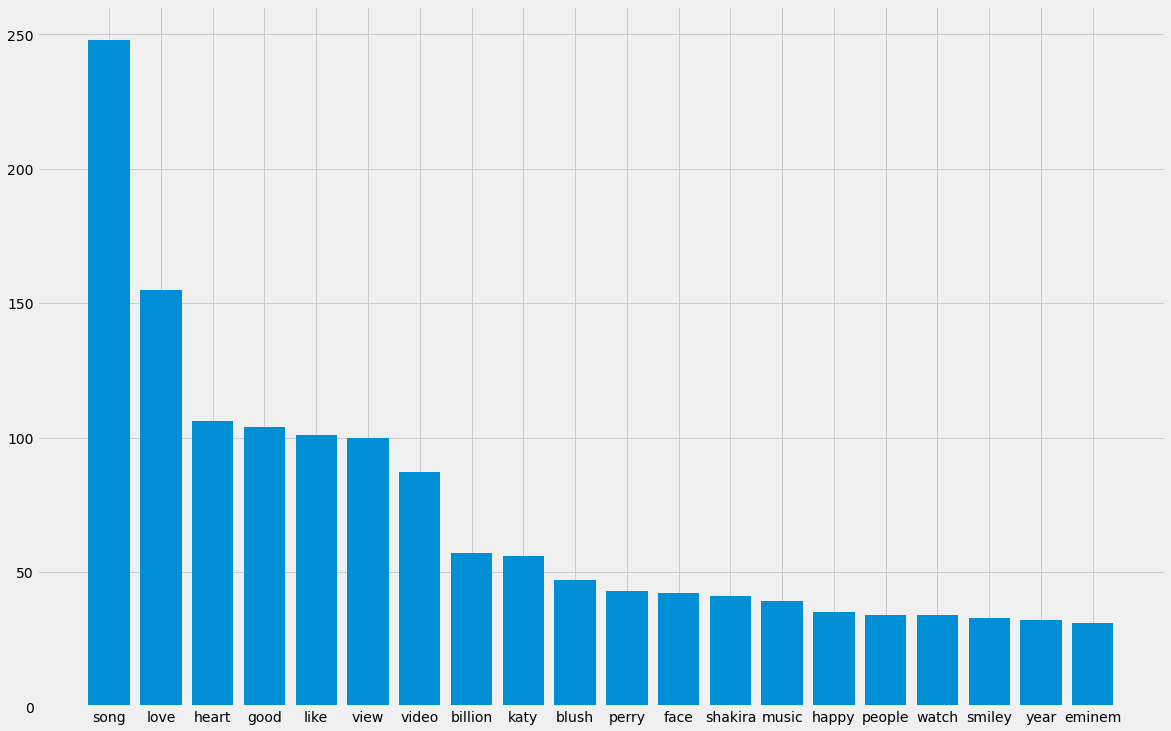

In [20]:
df_tempt = df[df['CLASS'] == 0]
w = dict(Counter([i for j in df_tempt['CONTENT_EDITED'].str.split().tolist() for i in j]).most_common(20))
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18, 12))
plt.bar(w.keys(), w.values())

Clearly class of spam has more invitation to urls and channels compare to not spam which is more about the song.

In [21]:
print(f"unique values count: {len(df['CONTENT_EDITED'].unique())}/{len(df['CONTENT_EDITED'].index)}")

unique values count: 1524/1953


In [22]:
# try to find the probability of author being spam writer
res = df[df['CLASS'] == 1].groupby('AUTHOR').size() / df.groupby('AUTHOR').size()
res = res.fillna(0)
for inx, item in tqdm(res.iteritems()):
    df.loc[df[df['AUTHOR'] == inx].index, 'AUTHOR_SPAM_PROB'] = item

1792it [00:00, 3542.14it/s]


In [23]:
df.to_parquet(path='dataset/youtube-agg-nlp-v1.parquet', engine='pyarrow')